In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

from src.utils import generate_style_dict, KStyledMNIST, KStyledMNISTGenerator

In [4]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST(
    "../data", train=True, download=True
)

style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]

In [5]:
def get_data_splits(k: int, seed: int, style_fns=style_fns):
    """
    Generate data splits and style dictionaries for k styled MNIST dataset

    Parameters:
        k (int): The number of styles to generate for each class
        seed (int): The random seed for reproducibility

    Returns:
        style_dict (dict): A dictionary containing the style information for each class
        train (k styled MNIST)
        valid (k styled MNIST)
        test (m-k styled MNIST)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    mnist = torchvision.datasets.MNIST("../data", train=True)
    mnist_train, mnist_test = random_split(mnist, [50000, 10000])
    style_dict = generate_style_dict(classes=list(range(10)), style_fns=style_fns, k=k)
    mnist_generator = KStyledMNISTGenerator(mnist_train, style_dict, "train", style_fns)
    train = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    mnist_generator = KStyledMNISTGenerator(mnist_test, style_dict, "test", style_fns)
    test = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    train_size = int(0.85 * len(train))
    train, valid = random_split(train, [train_size, len(train) - train_size])
    return style_dict, train, valid, test

In [6]:
style_dict, train, valid, test = get_data_splits(k=2, seed=101)

Generating dataset: 100%|██████████| 10000/10000 [00:06<00:00, 1651.18item/s]


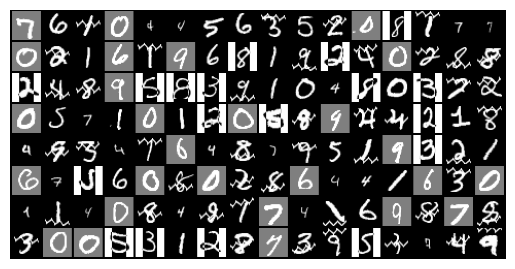

In [7]:
X, label, _ = next(iter(DataLoader(train, batch_size=128, shuffle=True)))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()

In [8]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [9]:
from ps_src import MLPTrainer

### with ps

In [49]:
mlp = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 2),
).to(device)
cls_head = nn.Linear(2, 10).to(device)
optimizer = torch.optim.Adam(
    list(mlp.parameters()) + list(cls_head.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()
trainer = MLPTrainer(mlp, cls_head, optimizer, criterion, verbose_period=5, device=device, pair_switch=True)
trainer.fit(
    epochs=41,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

val-epoch 0: 100%|██████████| 59/59 [00:00<00:00, 430.03it/s]


val_acc: 0.137


val-epoch 5: 100%|██████████| 59/59 [00:00<00:00, 429.95it/s]


val_acc: 0.329


val-epoch 10: 100%|██████████| 59/59 [00:00<00:00, 471.03it/s]


val_acc: 0.407


val-epoch 15: 100%|██████████| 59/59 [00:00<00:00, 429.20it/s]


val_acc: 0.422


val-epoch 20: 100%|██████████| 59/59 [00:00<00:00, 372.46it/s]


val_acc: 0.472


val-epoch 25: 100%|██████████| 59/59 [00:00<00:00, 437.81it/s]


val_acc: 0.491


val-epoch 30: 100%|██████████| 59/59 [00:00<00:00, 448.16it/s]


val_acc: 0.545


val-epoch 35: 100%|██████████| 59/59 [00:00<00:00, 471.15it/s]


val_acc: 0.55


val-epoch 40: 100%|██████████| 59/59 [00:00<00:00, 448.94it/s]

val_acc: 0.557


In [51]:
(aupr_score, auroc_score), acc = trainer.evaluate(
    test_loader, False, 0
)
print(f"test_acc: {round(float(acc), 3)}")
print(f"test_aupr: {aupr_score}")
print(f"test_auroc: {auroc_score}")

test_acc: 0.259
test_aupr: {0: 0.305, 1: 0.193, 2: 0.476, 3: 0.375, 4: 0.379, 5: 0.133, 6: 0.221, 7: 0.237, 8: 0.144, 9: 0.402}
test_auroc: {0: 0.784, 1: 0.634, 2: 0.823, 3: 0.771, 4: 0.847, 5: 0.631, 6: 0.791, 7: 0.735, 8: 0.642, 9: 0.781}


In [52]:
hs = []
outcome_labels = []
style_labels = []
for batch in valid_loader:
    X_batch, y_batch, label_batch = (
        batch[0].view(-1, 784).to(device),
        batch[1].view(-1).long().to(device),
        batch[-1].view(-1).long().to(device),
    )
    h = mlp(X_batch)
    hs.append(h)
    style_labels.append(label_batch)
    outcome_labels.append(y_batch)
hs, outcome_labels, style_labels = (
    torch.cat(hs),
    torch.cat(outcome_labels),
    torch.cat(style_labels),
)
hs = hs.detach().cpu().numpy()
outcome_labels = outcome_labels.cpu().numpy()
style_labels = style_labels.cpu().numpy()

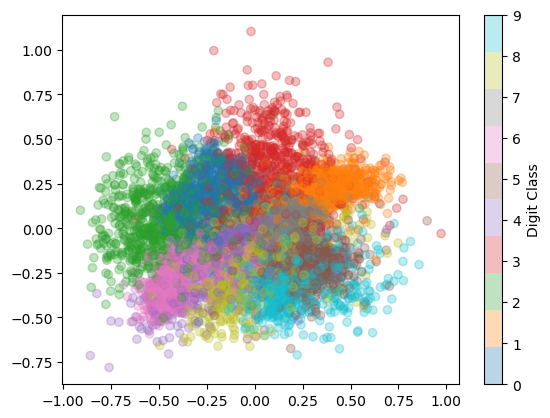

In [53]:
plt.scatter(hs[:, 0], hs[:, 1], alpha=0.3, 
            c=outcome_labels, cmap='tab10')
plt.colorbar(label='Digit Class')

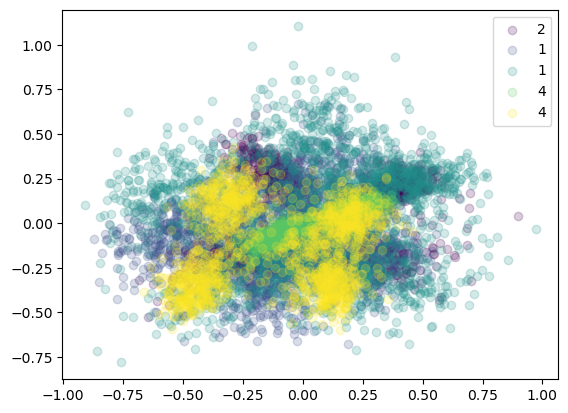

In [54]:
styles = ['identity', 'stripe', 'zigzag', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(styles))]

fig, ax = plt.subplots()
for g in range(len(styles)):
    i = np.where(style_labels == g)[0]
    ax.scatter(hs[i,0], hs[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

### without ps

In [55]:
mlp = nn.Sequential(
    nn.Linear(784, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 2),
).to(device)
cls_head = nn.Linear(2, 10).to(device)
optimizer = torch.optim.Adam(
    list(mlp.parameters()) + list(cls_head.parameters()), lr=1e-3
)
criterion = nn.CrossEntropyLoss()
trainer = MLPTrainer(mlp, cls_head, optimizer, criterion, verbose_period=5, device=device, pair_switch=False)
trainer.fit(
    epochs=41,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

val-epoch 0: 100%|██████████| 59/59 [00:00<00:00, 396.10it/s]


val_acc: 0.603


val-epoch 5: 100%|██████████| 59/59 [00:00<00:00, 410.01it/s]


val_acc: 0.824


val-epoch 10: 100%|██████████| 59/59 [00:00<00:00, 382.18it/s]


val_acc: 0.831


val-epoch 15: 100%|██████████| 59/59 [00:00<00:00, 429.08it/s]


val_acc: 0.847


val-epoch 20: 100%|██████████| 59/59 [00:00<00:00, 455.87it/s]


val_acc: 0.745


val-epoch 25: 100%|██████████| 59/59 [00:00<00:00, 404.88it/s]


val_acc: 0.894


val-epoch 30: 100%|██████████| 59/59 [00:00<00:00, 356.37it/s]


val_acc: 0.911


val-epoch 35: 100%|██████████| 59/59 [00:00<00:00, 402.93it/s]


val_acc: 0.74


val-epoch 40: 100%|██████████| 59/59 [00:00<00:00, 430.15it/s]


val_acc: 0.856


In [56]:
(aupr_score, auroc_score), acc = trainer.evaluate(
    test_loader, False, 0
)
print(f"test_acc: {round(float(acc), 3)}")
print(f"test_aupr: {aupr_score}")
print(f"test_auroc: {auroc_score}")

test_acc: 0.196
test_aupr: {0: 0.192, 1: 0.242, 2: 0.209, 3: 0.167, 4: 0.135, 5: 0.162, 6: 0.207, 7: 0.179, 8: 0.128, 9: 0.303}
test_auroc: {0: 0.641, 1: 0.79, 2: 0.659, 3: 0.572, 4: 0.58, 5: 0.716, 6: 0.538, 7: 0.543, 8: 0.607, 9: 0.642}


In [57]:
hs = []
outcome_labels = []
style_labels = []
for batch in valid_loader:
    X_batch, y_batch, label_batch = (
        batch[0].view(-1, 784).to(device),
        batch[1].view(-1).long().to(device),
        batch[-1].view(-1).long().to(device),
    )
    h = mlp(X_batch)
    hs.append(h)
    style_labels.append(label_batch)
    outcome_labels.append(y_batch)
hs, outcome_labels, style_labels = (
    torch.cat(hs),
    torch.cat(outcome_labels),
    torch.cat(style_labels),
)
hs = hs.detach().cpu().numpy()
outcome_labels = outcome_labels.cpu().numpy()
style_labels = style_labels.cpu().numpy()

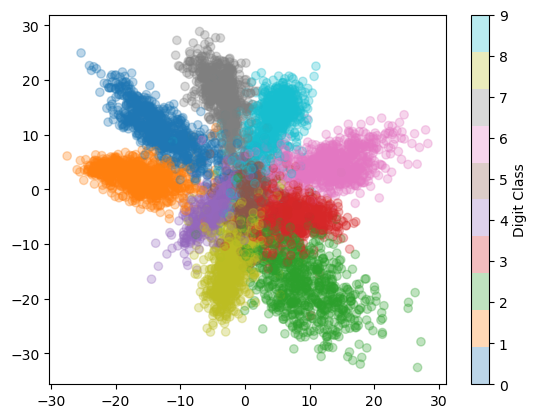

In [58]:
plt.scatter(hs[:, 0], hs[:, 1], alpha=0.3, 
            c=outcome_labels, cmap='tab10')
plt.colorbar(label='Digit Class')

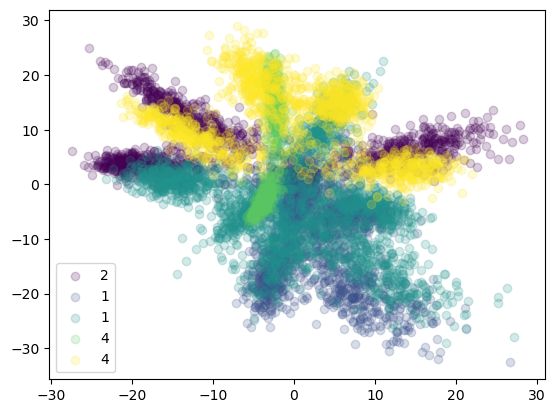

In [59]:
styles = ['identity', 'stripe', 'zigzag', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(styles))]

fig, ax = plt.subplots()
for g in range(len(styles)):
    i = np.where(style_labels == g)[0]
    ax.scatter(hs[i,0], hs[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()